> 💡 I have trained model separately because it was time consuming and uploaded the model weights and subset of dataset on my github repo to demostrate here.

## ✍️ The task that was assigned is known Image Quality Assessment. <br/>
> We wanted train an end to end deep learning model to predict <mark>Quality</mark> of an Image. <br/>
There are two types of quality <br/>
- Aesthetic Quality: which means how nice does that image to feels to us. <br/>
- Technical Quality: This means how clear and Informative the image is i.e with respect to resolution of image. For example is everything clearly visible in image or is it blurry.

> We have two ways to train such model to predict quality <br/>
- <mark>Regression</mark>: In this we predict the quality score as continuous numerical variable
- <mark>Classification</mark>: In this we convert problem into classification type with num of classes equal to the integral range of quality scores. For example if scores are from 1-10 than this becomes 10 class classification problem


> The type of model i am using here is <mark>Regression </mark>Type because it becomes easier to  use Mean Squared Error loss function. why only Mean Squared Error? I will explain about it later in notebook.

## Information of my Project
> Here dataset used by me is <mark> Petfinder Dataset </mark> which was launched by petfinder.com which helps people adopt stray animals. <br/>
This dataset contains images of cats and dogs in variety of conditions and all images have ratings associated with it, that is how often photo of particular pet was visited which correlates with popularity of that pet.

## 🧰 Required Libraries

In [ ]:
#====================#
#  torch imports     #
#====================#
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data 
from torch.utils.tensorboard import SummaryWriter

#========================#
#  torchvision imports   #
#========================#
import torchvision
from torchvision import transforms, models, datasets

#========================#
#  common utilities      #
#========================#
import gc
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm

## Dataset

> Dataset contains approx 10000 image <br/>
- train-split: 7000 <br/>
- val_split: 3000

In [ ]:
class PetDataset(data.Dataset):
    def __init__(self, root, df, tfms=None):
        self.tfms = tfms
        self.root = root
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df['Id'][idx]
        fname = image + '.jpg'
        image = cv2.imread(os.path.join(self.root, fname))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.tfms:
            image = self.tfms(image)
        label = self.df['Pawpularity'][idx]
        return image, label

In [ ]:
test_df = pd.read_csv('./label.csv')

In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

In [ ]:
test_ds = PetDataset('./test', test_df, tfms=tfms)

In [ ]:
# freezing model parameters this was done during training
def freeze(model, unfreeze=False):
    for param in model.parameters():
        param.requires_grad = unfreeze

In [ ]:
test_dl = data.DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
# display single batch of image
def display_batch(batch):
    image = torchvision.utils.make_grid(batch)
    image = image.permute(1, 2, 0)
    plt.figure(figsize=(10, 10))
    plt.title('Sample Batch')
    plt.imshow(image)
    plt.tight_layout()
    plt.axis('off')

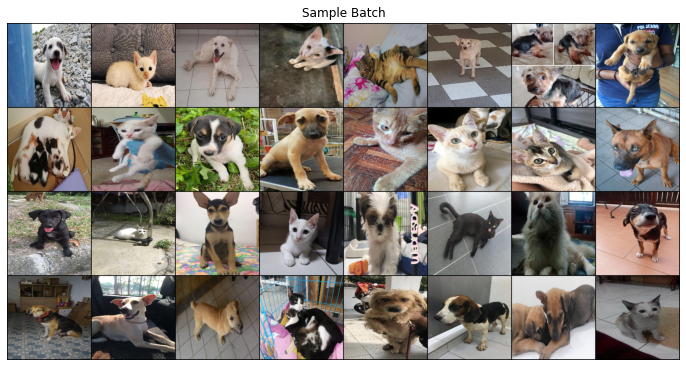

In [ ]:
image, label = next(iter(test_dl))
display_batch(image)

## 🤖 Model

> I have used Resnet-50 on pretrained on Imagenet and freeze all the weights except last Linear layer.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=10, regression=True, freeze_model=True):
        super().__init__()
        model = models.resnet50(pretrained=True) # pretrained resnet model
        if freeze_model:
            freeze(model)
        if regression:
            model.fc = nn.Sequential(nn.ReLU(),
                                     nn.Dropout(0),
                                     nn.Linear(model.fc.in_features, 1))
                                     
        else:
            model.fc = nn.Sequential(nn.ReLU(),
                                     nn.Dropout(0),
                                     nn.Linear(model.fc.in_features, num_classes))
        
        self.model = model

    def forward(self, x):
        out = self.model(x)
        return out

# Loss Function <br/>
> We are using Mean Squared Error as our loss function because aesthetic quality are ratings are very subjective and somewhat ambiguous. <br/>
For example if ratings range from 1-10 than ratings 8, 10 both can be considerd good and thus any one could rate anything between 8-10 and there is no clear boundary between good and bad ratings.<br/>
If we use Classification type model than we have use Cross-Entropy loss which consider every class independent of each other and it penalizes model equally if models predictions for target 10 is 8 or 1. <br/>
But if we pay attention than we can see that model is doing pretty good job if it predicts 8 for target 10 and does bad job if it predict 1 for target 8. And Mean Squared Error Loss function captures this logic as it will penalize prediction 1 more than 8 based on the distance of prediction with ground truth.

In [ ]:
model = Model(regression=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# loading pretrained weights
state_dict = torch.load(./model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model_state'])

<All keys matched successfully>

In [ ]:
# to predict on one batch of dataloader
def predict(batch):
    data, label = batch
    model.eval()
    with torch.no_grad():
        out = model(data)
    preds = out.squeeze(1)
    
    fig, axs = plt.subplots(4, 8, figsize=(15, 15))
    fig.suptitle('model predictions')
    for i, ax in enumerate(axs.flatten()):
        ax.set_title(f'pred: {round(preds[i].item())} \nGround_Truth: {label[i].item()}')
        ax.imshow(data[i].permute(1, 2, 0))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

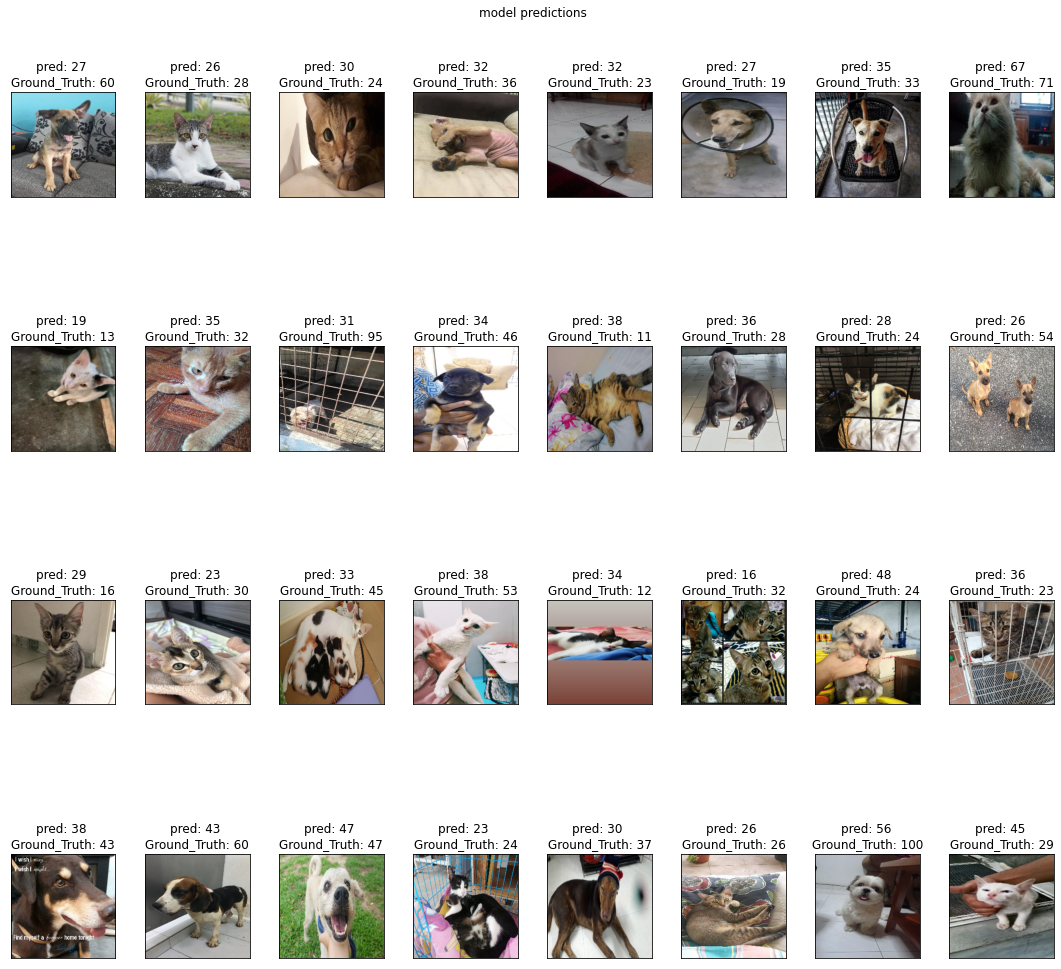

In [ ]:
# try running this cell again to see new predictions because shuffle option 
# is turned on which shows new batch every time due
batch = next(iter(test_dl))
predict(batch)

## ⚡ Inference

> The Pawpularity ranges from 1 to 100 and it is rounded to integers. The target follows that distribution with a mean average of 38.04 and a standard deviation of 20.59, that means if you predict 38.04 for all images then the RMSE score is 20.59. Any model that scores lower than 20.59 is considered to have some predictive power. <br/> The model that i have trained has validation RMSE score 18.65.
<br/>That means model definitely has some predictive power.
I have also participated in this competition on kaggle but at that time my performance was not good. The top solution has in this competition had RMSE score of 16.82, which was ensemble of several models.


# Key Ideas For Improvement
> - Training two separate models for Technical and Aesthetic Quality from NIMA paper from Google. <br/>
- Using perceptual loss to train Technical Quality Model yields better performance. <br/>
- Training Ensembles of good and diverse models and doing Knowledge Distillation to obtain Single small model which can be deployed in production Efficiently.
- Using Self Supervised Learning for pretraining.
- Using Generative models to Generate more data using methods like GANs, AutoEncoder, Diffusion Models etc.


# References
- [Deep Perceptual Image Quality Assessment for Compression](https://arxiv.org/abs/2103.01114) <br/>
- [On the Use of Deep Learning for Blind Image Quality Assessment](https://arxiv.org/abs/1602.05531) <br/>
- [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424)
